In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from fuzzywuzzy import process
import time
from uszipcode import SearchEngine
search = SearchEngine()

import utils as u
import init
init.run()
from config.GLOBAL import *

C:\Users\steff\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
#read-in forecast
df = pd.read_csv("results/model~1/predictions.csv")
df = df.convert_dtypes()
df["time"] = pd.to_datetime(df["time"]).dt.date
df["date"] = pd.to_datetime(df["date"]).dt.date

df = df.rename(columns={"Unnamed..0" : "tract-time"})

df = df.set_index(["date", "census_tract_2010"])
df.index.dtypes[1] = "int64"
df = df.replace(0.01, 0)
df

C:\Users\steff\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (3,4,34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Unnamed: 0              tract-time        time  \
date       census_tract_2010                                                   
2011-01-31 53001950100                 1  53001950100-2011-01-31  2011-01-31   
           53001950200                 2  53001950200-2011-01-31  2011-01-31   
           53001950300                 3  53001950300-2011-01-31  2011-01-31   
           53001950400                 4  53001950400-2011-01-31  2011-01-31   
           53001950500                 5  53001950500-2011-01-31  2011-01-31   
...                                  ...                     ...         ...   
2035-12-31 53077940002            431096                    <NA>         NaN   
           53077940003            431097                    <NA>         NaN   
           53077940004            431098                    <NA>         NaN   
           53077940005            431099                    <NA>         NaN   
           53077940006            431100                    <NA>         NaN   

                              county  zip_code  n_ev  n_bev  n_phev  m_ev  \
date       census_tract_2010                                                
2011-01-31 53001950100         Adams     99169   0.0    0.0     0.0     7   
           53001950200         Adams     99371   0.0    0.0     0.0     7   
           53001950300         Adams     99344   0.0    0.0     0.0     7   
           53001950400         Adams     99344   0.0    0.0     0.0     7   
           53001950500         Adams     99344   0.0    0.0     0.0     7   
...                              ...       ...   ...    ...     ...   ...   
2035-12-31 53077940002        Yakima     98948  <NA>   <NA>    <NA>  <NA>   
           53077940003        Yakima     98903  <NA>   <NA>    <NA>  <NA>   
           53077940004        Yakima     98951  <NA>   <NA>    <NA>  <NA>   
           53077940005        Yakima     98948  <NA>   <NA>    <NA>  <NA>   
           53077940006        Yakima     98948  <NA>   <NA>    <NA>  <NA>   

                              m_bev  ...  p_ev_log_odds_predict  p_ev_predict  \
date       census_tract_2010         ...                                        
2011-01-31 53001950100            6  ...             -14.130161      0.000001   
           53001950200            6  ...             -16.943662           0.0   
           53001950300            6  ...             -14.578062           0.0   
           53001950400            6  ...             -16.423694           0.0   
           53001950500            6  ...             -15.307598           0.0   
...                             ...  ...                    ...           ...   
2035-12-31 53077940002         <NA>  ...                   <NA>          <NA>   
           53077940003         <NA>  ...                   <NA>          <NA>   
           53077940004         <NA>  ...                   <NA>          <NA>   
           53077940005         <NA>  ...                   <NA>          <NA>   
           53077940006         <NA>  ...                   <NA>          <NA>   

                              p_ev_res  fixeff_i  t_dummy_predict  \
date       census_tract_2010                                        
2011-01-31 53001950100       -0.000004       0.0                1   
           53001950200       -0.000007 -2.905202                1   
           53001950300       -0.000001 -0.418235                1   
           53001950400       -0.000005 -2.304883                1   
           53001950500       -0.000002 -1.290576                1   
...                                ...       ...              ...   
2035-12-31 53077940002            <NA>  -1.58364              300   
           53077940003            <NA> -1.470011              300   
           53077940004            <NA> -2.144669              300   
           53077940005            <NA> -2.749912              300   
           53077940006            <NA> -1.831687              300   

                              fixef

In [53]:
# df_WA_by_year = df.groupby(level=["date"])["n_veh", "n_ev"].sum()
df_WA = df.groupby(level=["date"])["n_veh", "n_ev_forecast", "n_ev"].sum()
df_WA["p_ev_forecast"] = df_WA["n_ev_forecast"] / df_WA["n_veh"]
df_WA["p_ev"] = df_WA["n_ev"] / df_WA["n_veh"]
# print((df_WA["p_ev"]==0).sum())
# df_WA.loc[df_WA["p_ev"]==0, "p_ev"] = None
df_WA

C:\Users\steff\AppData\Local\Temp/ipykernel_19072/1589005916.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_WA = df.groupby(level=["date"])["n_veh", "n_ev_forecast", "n_ev"].sum()


,n_veh,n_ev_forecast,n_ev,p_ev_forecast,p_ev
date,,,,,
2011-01-31,5830621,25.613996,90.0,0.000004,0.000015
2011-02-28,5790589,35.382112,109.0,0.000006,0.000019
2011-03-31,5854787,47.991243,112.0,0.000008,0.000019
2011-04-30,5910444,63.617333,153.0,0.000011,0.000026
2011-05-31,5911242,81.941118,233.0,0.000014,0.000039
...,...,...,...,...,...
2035-08-31,5974507,917984.638991,0.0,0.15365,0.0
2035-09-30,5974507,924568.120196,0.0,0.154752,0.0
2035-10-31,5974507,931163.250066,0.0,0.155856,0.0


1.790055648106195


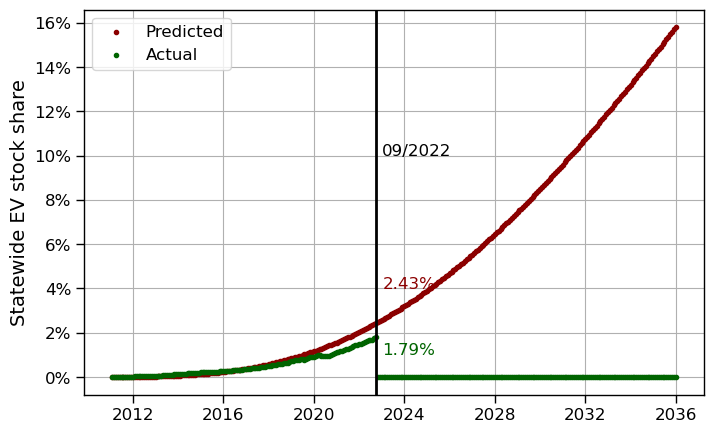

In [56]:
fig,ax = plt.subplots(figsize=(8,5))
u.plot(df_WA.index, df_WA["p_ev_forecast"]*100, frame=[fig,ax], color="darkred", label="Predicted")
u.plot(df_WA.index, df_WA["p_ev"]*100, frame=[fig,ax], color="darkgreen", label="Actual")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

today = pd.to_datetime("2022-09-30").date()
p_ev_WA_today_predicted = df_WA.loc[today, "p_ev_forecast"]*100
p_ev_WA_today = df_WA.loc[today, "p_ev"]*100
print(p_ev_WA_today)
ax.axvline(today, color="black", lw=2, zorder=2)
ax.text(today+pd.Timedelta(days=100), 10, "09/2022", color="black")
ax.text(today+pd.Timedelta(days=100), 4, "%.2f%%"%p_ev_WA_today_predicted, color="darkred")
ax.text(today+pd.Timedelta(days=100), 1, "%.2f%%"%p_ev_WA_today, color="darkgreen")

u.fig_ax_setup(fig, ylabel="Statewide EV stock share")
u.save_figure(fig, "results/model~1/p_ev_WA_forecast.png", dpi=400)

In [59]:
date = pd.to_datetime("2035-12-31").date()
df_WA.loc[date, "n_ev_forecast"]

944387.8038594978